Общее описание проекта:
- Соревнование представляет собой увлекательный и практически важный опыт, ориентированный на студентов курса Data Science. 
- Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. 
- Соревнование проводится на популярной платформе Kaggle, что позволяет участникам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой.


Цель проекта:
- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. Предсказать значение 'status' для каждого стартапа.
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

Описание данных:
- Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). 
- Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. 
- Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
- name - идентификатор (название) стартапа в тестовом наборе.
- status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

Описание полей данных:
* `name` - Название стартапа
* `category_list` - Список категорий, к которым относится стартап
* `funding_total_usd` - Общая сумма финансирования в USD
* `status` - Статус стартапа (закрыт или действующий)
* `country_code` - Код страны
* `state_code` - Код штата
* `region` - Регион
* `city` - Город
* `funding_rounds` - Количество раундов финансирования
* `founded_at` - Дата основания
* `first_funding_at` - Дата первого раунда финансирования
* `last_funding_at` - Дата последнего раунда финансирования
* `closed_at` - Дата закрытия стартапа (если применимо)
* `lifetime` - Время существования стартапа в днях

План проекта:
- Загрузка и ознакомление с данными,
- Предварительная обработка,
- Полноценный разведочный анализ,
- Разработка новых синтетических признаков,
- Проверка на мультиколлинеарность,
- Отбор финального набора обучающих признаков,
- Выбор и обучение моделей,
- Итоговая оценка качества предсказания лучшей модели,
- Анализ важности ее признаков,
- Подготовка отчета по исследованию.

Установка библиотек:

In [85]:
# выполняю установку библиотек в "тихом" режиме
! pip install -q missingno
! pip install -q levenshtein
! pip install -q jupyter_bokeh
! pip install -q ydata-profiling
! pip install -q sweetviz
! pip install -q autoviz
! pip install -q phik
! pip install -q optuna-integration
! pip install -q shap


In [86]:
# импортирую библиотеки
import numpy as np
import pandas as pd
import os
import missingno as msno
import math
import matplotlib.pyplot as plt
import seaborn as sns
from Levenshtein import distance as lev
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from IPython.display import display
import warnings

import phik
from phik.report import plot_correlation_matrix
import sweetviz as sv
from optuna.integration import OptunaSearchCV
from optuna import distributions
import shap
from ydata_profiling import ProfileReport

# Загрузка данных:

In [87]:
train = pd.read_csv('kaggle_startups_train_28062024.csv')
test = pd.read_csv('kaggle_startups_test_28062024.csv')
sample = pd.read_csv('/Users/erofeev-as/Desktop/dev/git_masterskaya_1/kaggle_startups_sample_submit_28062024.csv')

Создаю переменные и сохраняю размер датафреймов

In [88]:

train_shape = train.shape
test_shape = test.shape

In [89]:
train.head()


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [90]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [91]:
sample.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


Данные успешно загружены

# Предобработка данных и исследовательский анализ

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52473 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52473 non-null  object        
 1   category_list           52473 non-null  object        
 2   funding_total_usd       52473 non-null  float64       
 3   status                  52473 non-null  object        
 4   country_code            52473 non-null  object        
 5   state_code              52473 non-null  object        
 6   region                  52473 non-null  object        
 7   city                    52473 non-null  object        
 8   funding_rounds          52473 non-null  int64         
 9   founded_at              52473 non-null  datetime64[ns]
 10  first_funding_at        52473 non-null  datetime64[ns]
 11  last_funding_at         52473 non-null  datetime64[ns]
 12  closed_at               4912 non-null   datetime64[

In [113]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13123 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    13123 non-null  object        
 1   category_list           13123 non-null  object        
 2   funding_total_usd       13123 non-null  float64       
 3   country_code            13123 non-null  object        
 4   state_code              13123 non-null  object        
 5   region                  13123 non-null  object        
 6   city                    13123 non-null  object        
 7   funding_rounds          13123 non-null  int64         
 8   first_funding_at        13123 non-null  datetime64[ns]
 9   last_funding_at         13123 non-null  datetime64[ns]
 10  lifetime                13123 non-null  int64         
 11  lifetime_first_funding  13123 non-null  int64         
 12  lifetime_last_funding   13123 non-null  int64      

In [114]:
train.describe(include='all')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime_first_funding,lifetime_last_funding,lifetime
count,52473,52473,5.247300e+04,52473,52473,52473,52473,52473,52473.000000,52473,52473,52473,4912,52473.000000,52473.000000,52473.000000
unique,52473,22087,NaN,2,135,301,1037,4477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,lunchgate,software,NaN,operating,usa,ca,sf bay area,unknown_city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3206,NaN,47561,29680,10212,6966,6351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.514090e+07,NaN,NaN,NaN,NaN,NaN,1.740876,2008-11-03 15:19:00.037733632,2011-07-16 20:51:59.409982464,2012-06-27 10:10:42.570465024,2012-01-15 12:02:55.895765504,985.231243,1331.785909,3141.526118
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00,-9465.000000,-9465.000000,19.000000
25%,NaN,NaN,5.300000e+05,NaN,NaN,NaN,NaN,NaN,1.000000,2006-10-01 00:00:00,2009-10-10 00:00:00,2011-02-01 00:00:00,2009-09-15 18:00:00,214.000000,338.000000,1740.000000
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,NaN,1.000000,2010-10-01 00:00:00,2012-07-20 00:00:00,2013-08-30 00:00:00,2012-09-13 12:00:00,480.000000,679.000000,2557.000000
75%,NaN,NaN,6.800000e+06,NaN,NaN,NaN,NaN,NaN,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-21 06:00:00,977.000000,1643.000000,4018.000000
max,NaN,NaN,3.007950e+10,NaN,NaN,NaN,NaN,NaN,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00,16313.000000,16313.000000,17378.000000


In [115]:
test.describe(include='all')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,lifetime_first_funding,lifetime_last_funding
count,13123,13123,1.312300e+04,13123,13123,13123,13123,13123.000000,13123,13123,13123.000000,13123.0,13123.000000
unique,13123,6205,NaN,97,236,689,2118,NaN,NaN,NaN,NaN,NaN,NaN
top,crystalsol,software,NaN,usa,ca,sf bay area,unknown_city,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,775,NaN,7427,2552,1750,1587,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.369342e+07,NaN,NaN,NaN,NaN,1.714395,2011-07-23 16:54:54.124818944,2012-06-16 01:13:37.770326784,3097.850263,0.0,328.346338
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,1.000000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000000,0.0,0.000000
25%,NaN,NaN,5.014340e+05,NaN,NaN,NaN,NaN,1.000000,2009-11-15 12:00:00,2011-01-10 00:00:00,1726.000000,0.0,0.000000
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,1.000000,2012-08-01 00:00:00,2013-08-20 00:00:00,2526.000000,0.0,0.000000
75%,NaN,NaN,6.514723e+06,NaN,NaN,NaN,NaN,2.000000,2014-04-01 00:00:00,2014-11-11 00:00:00,3866.000000,0.0,390.500000
max,NaN,NaN,4.715000e+09,NaN,NaN,NaN,NaN,15.000000,2015-12-03 00:00:00,2015-12-12 00:00:00,17167.000000,0.0,7038.000000


                                             |          | [  0%]   00:00 -> (? left)


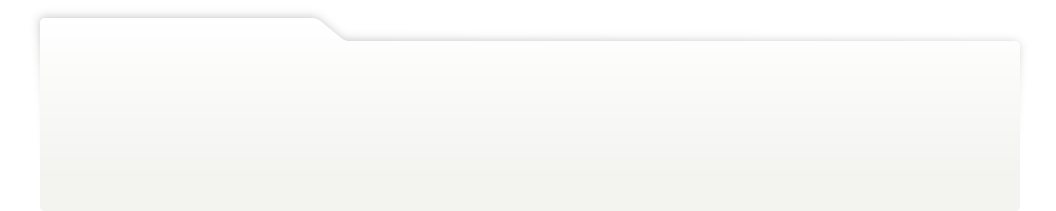
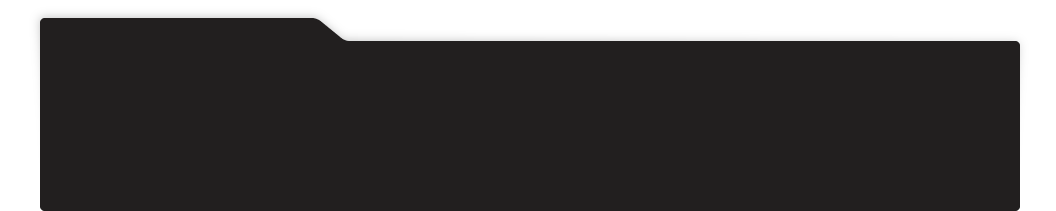
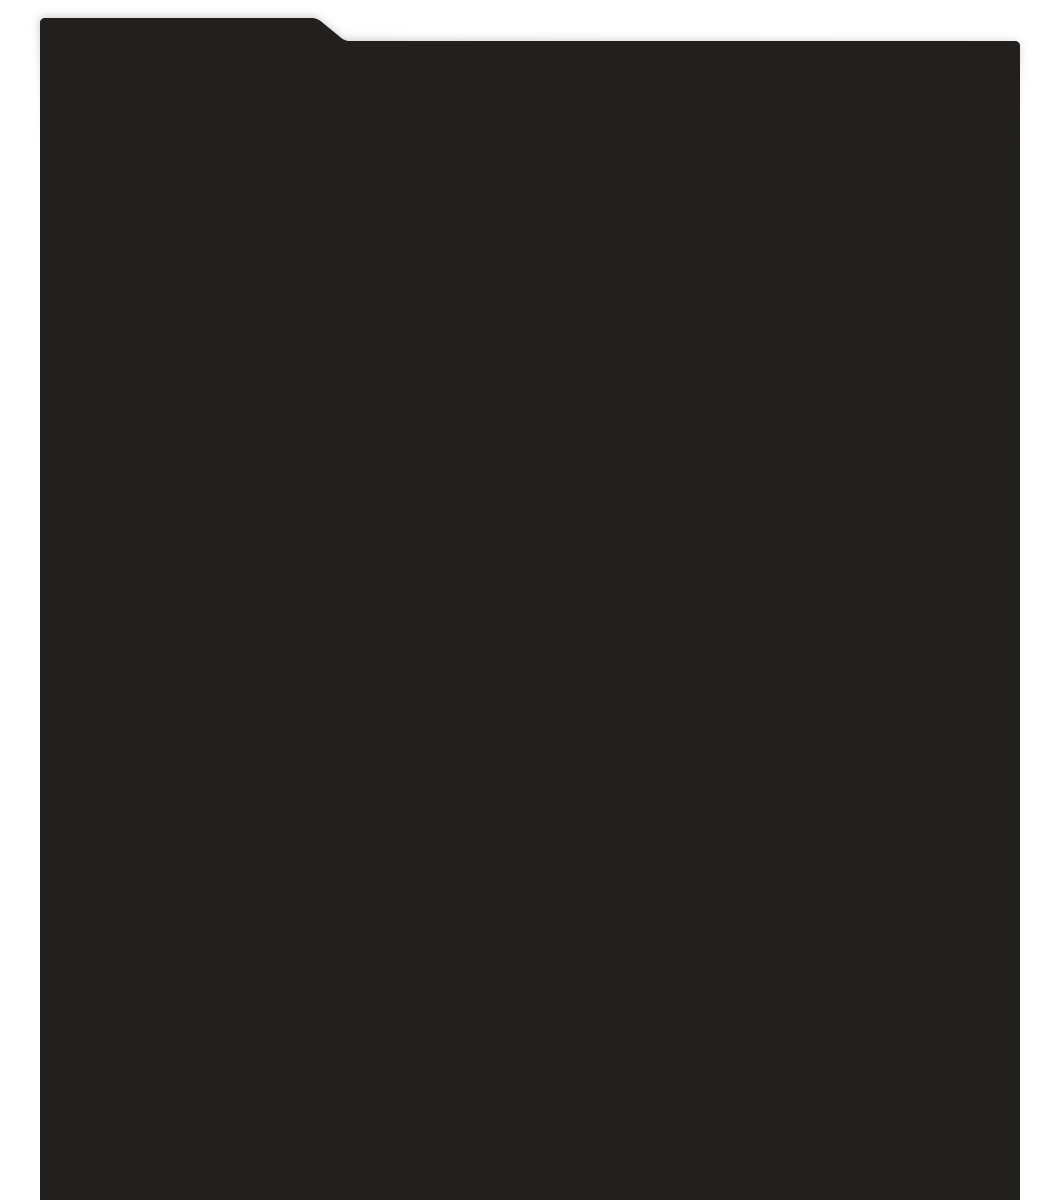
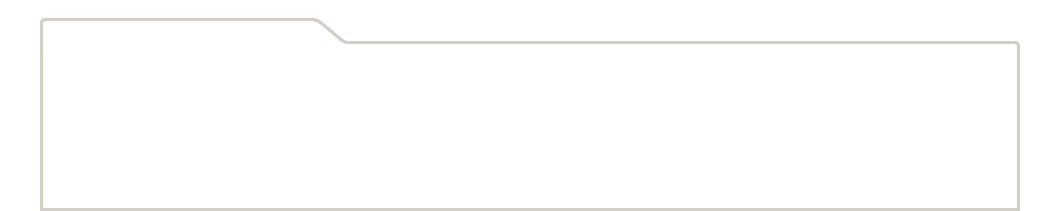
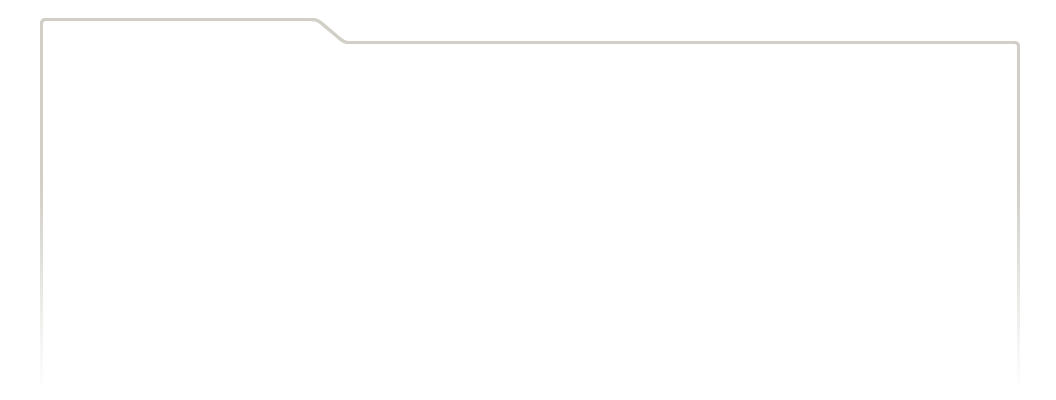
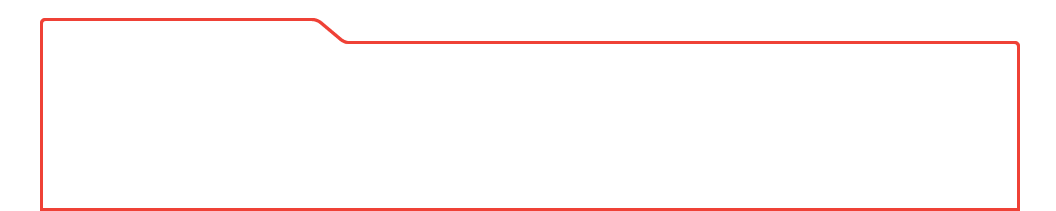
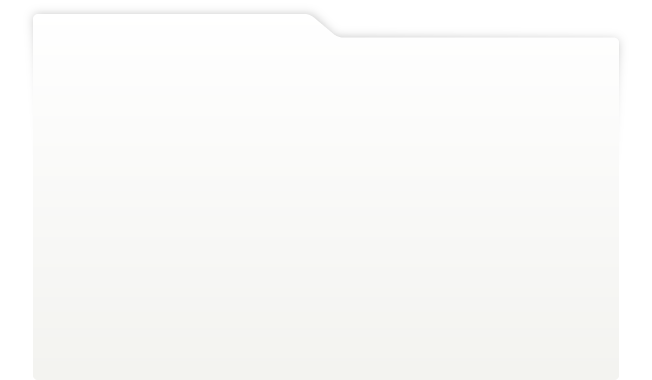
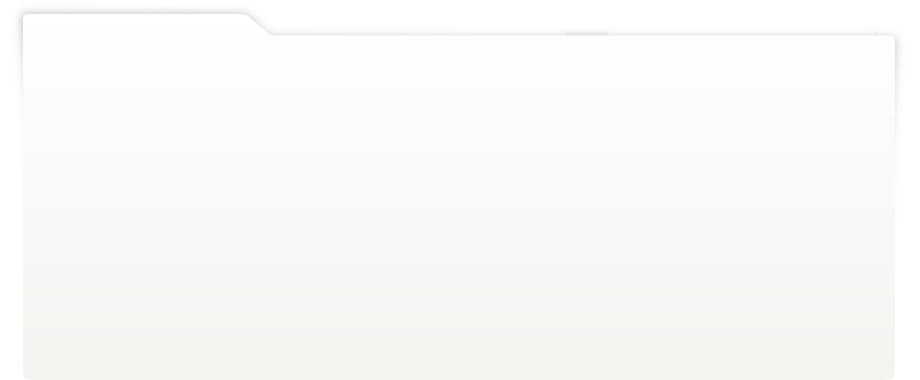
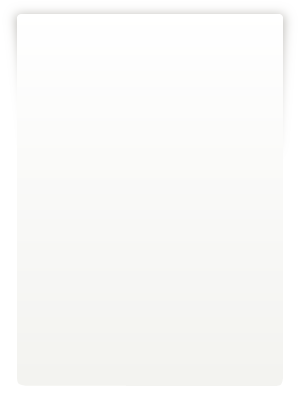
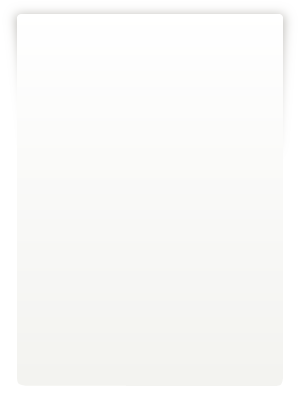
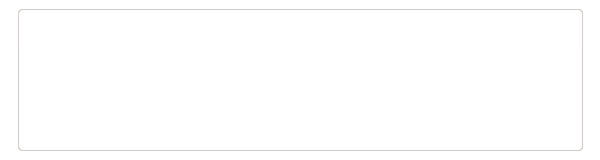
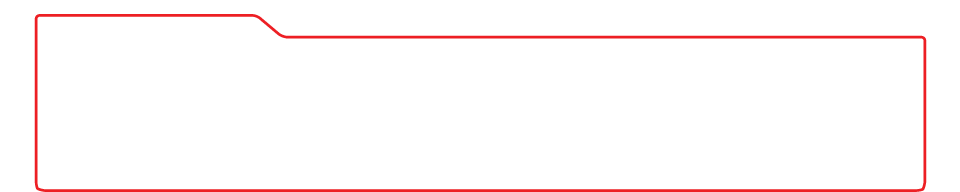
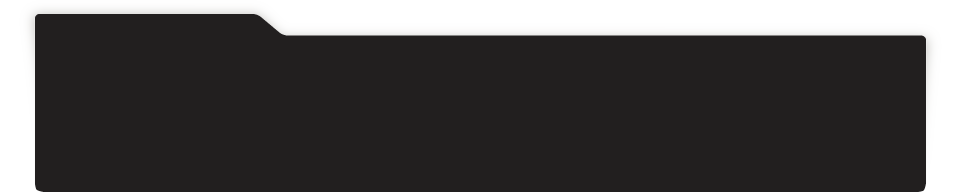
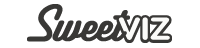
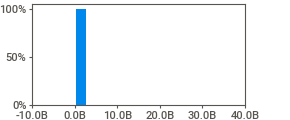
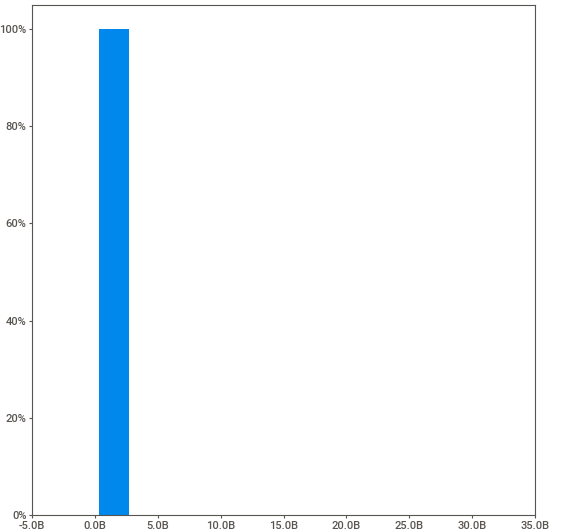
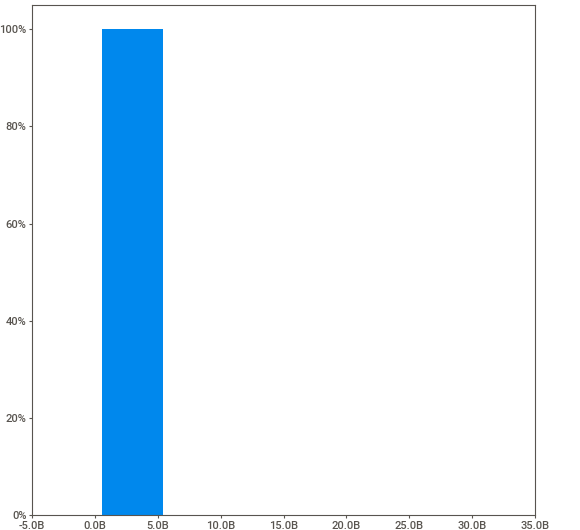
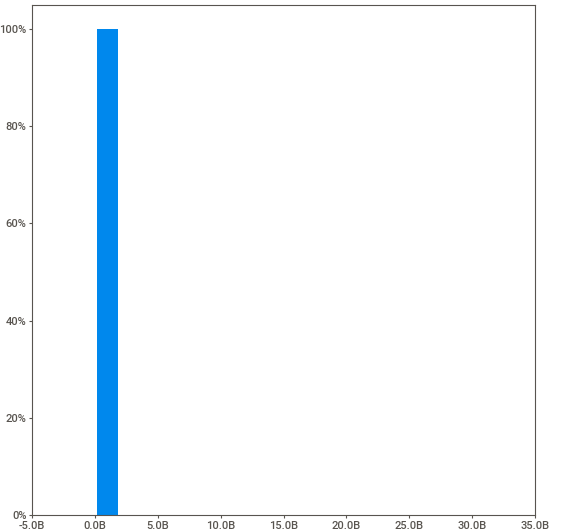
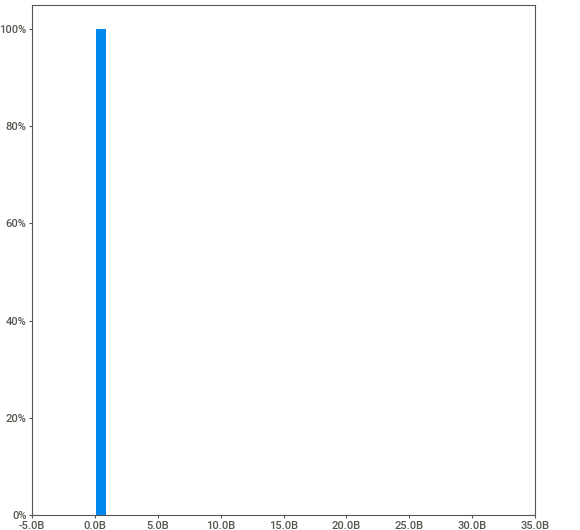
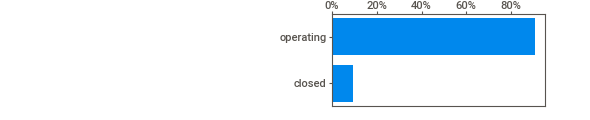
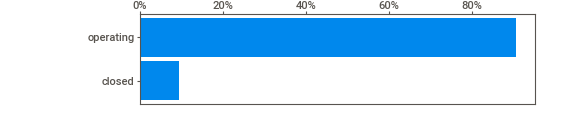
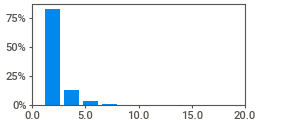
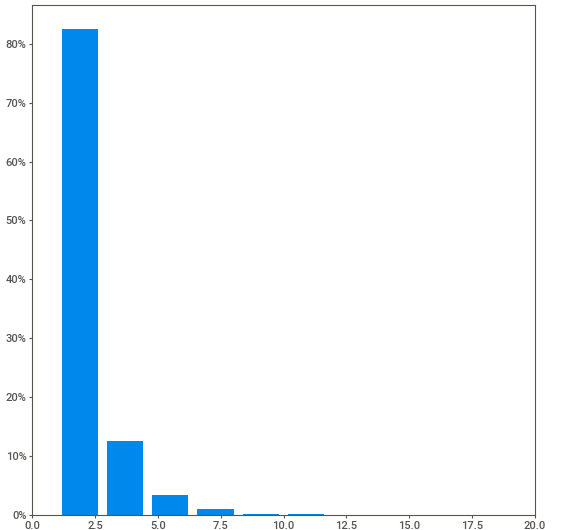
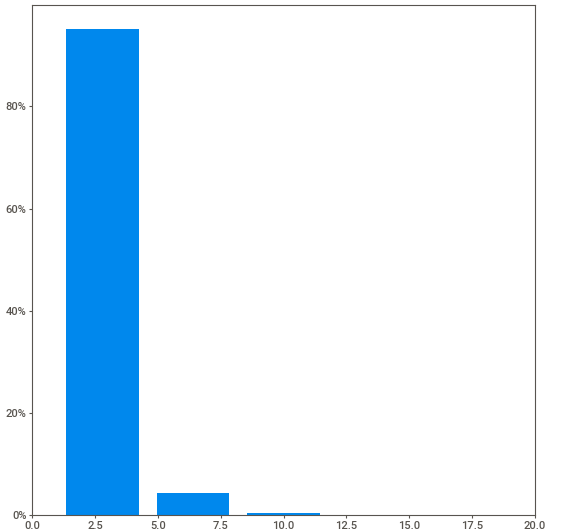
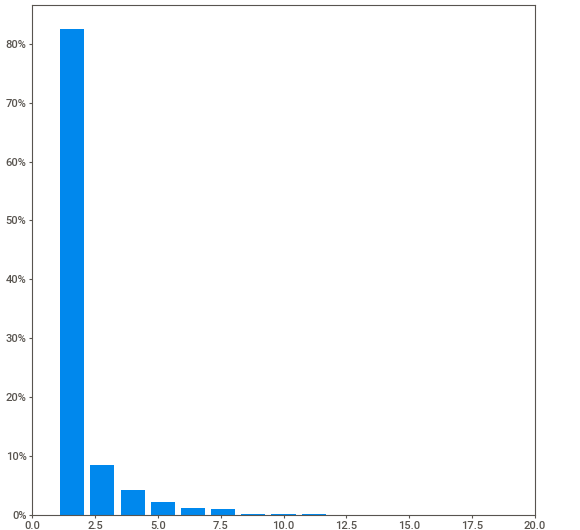
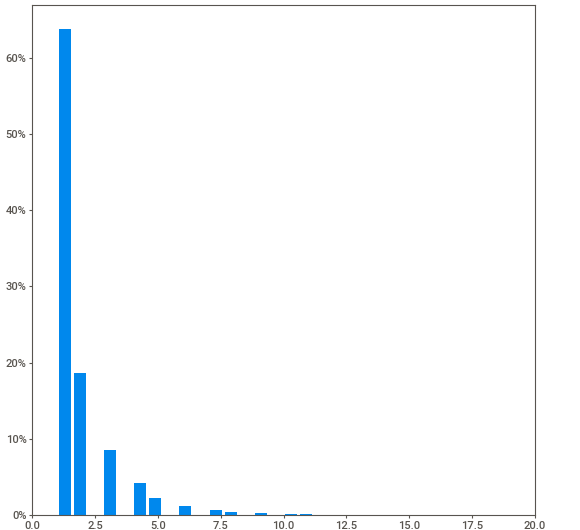
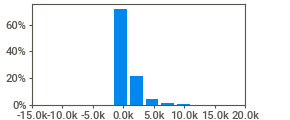
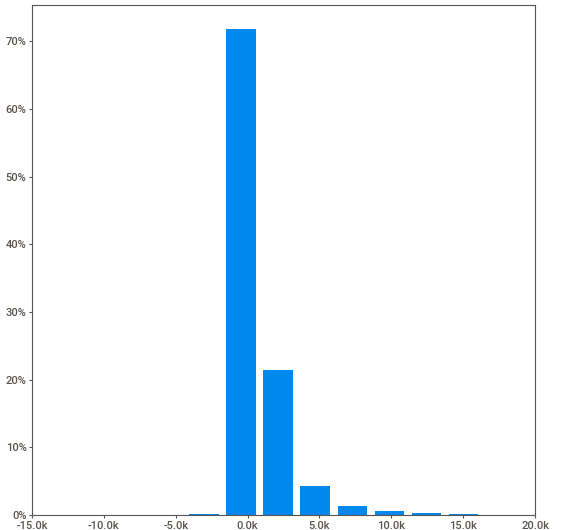
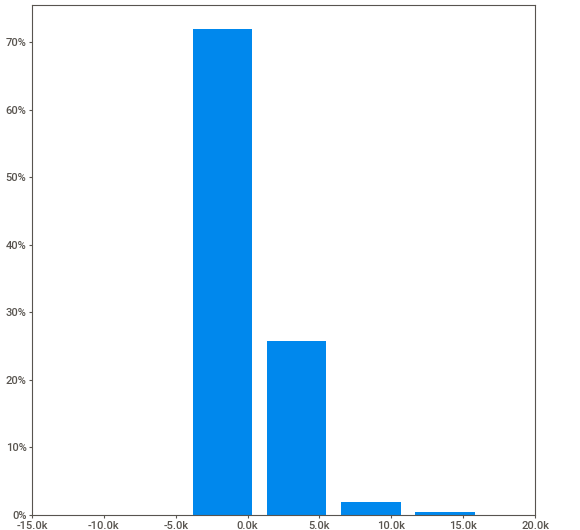
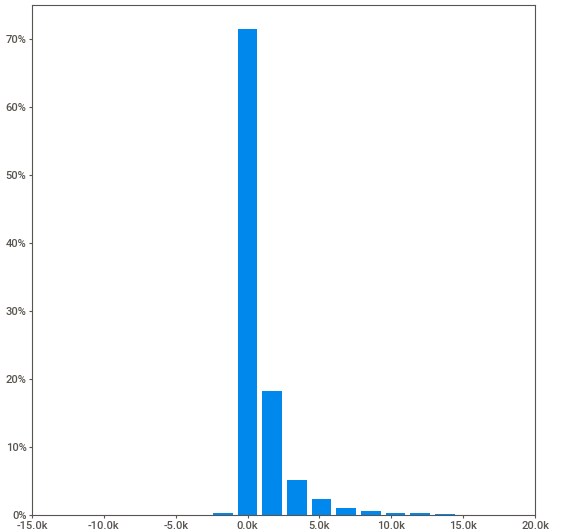
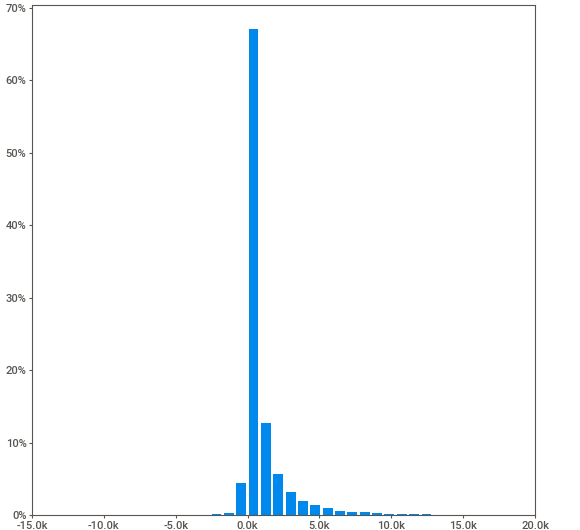
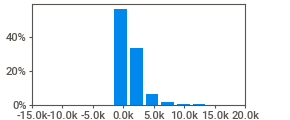
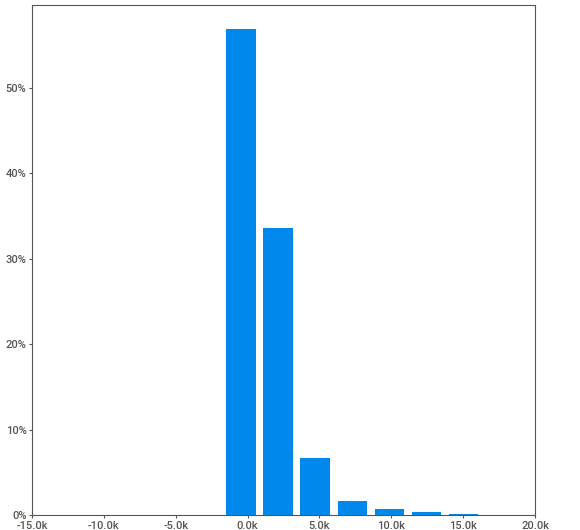
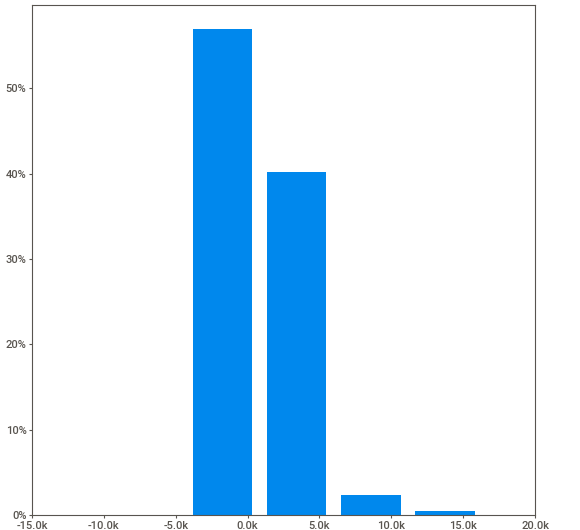
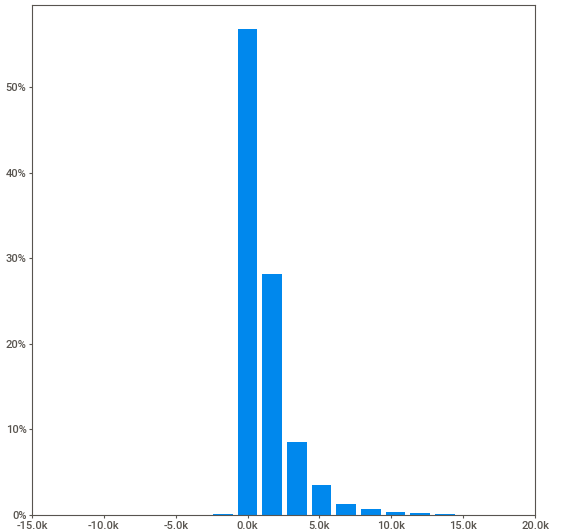
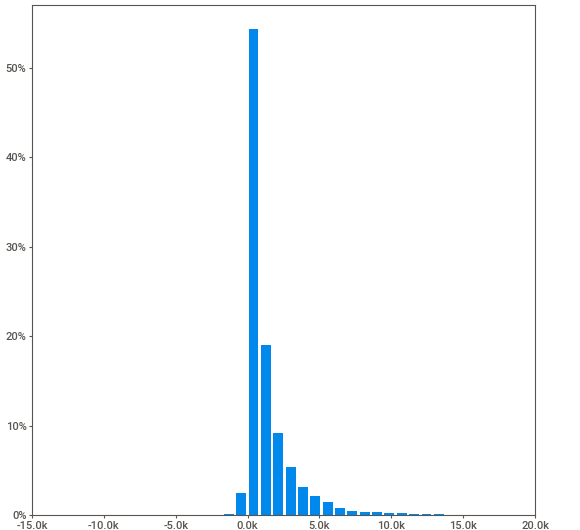
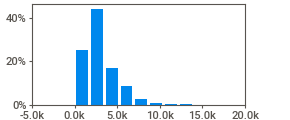
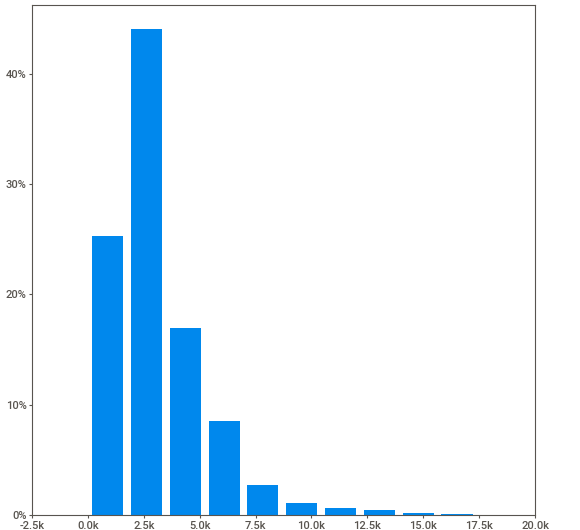
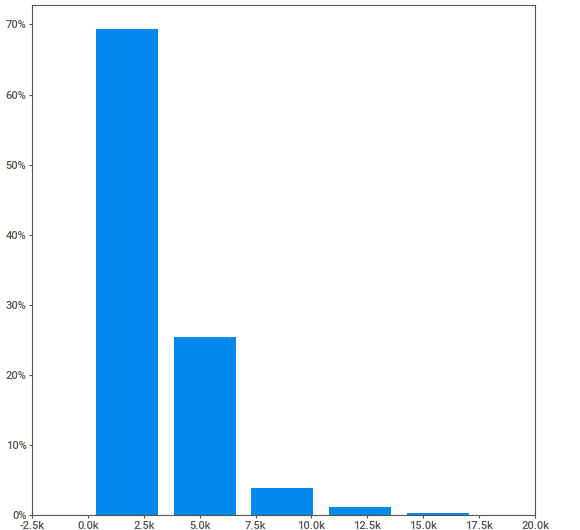
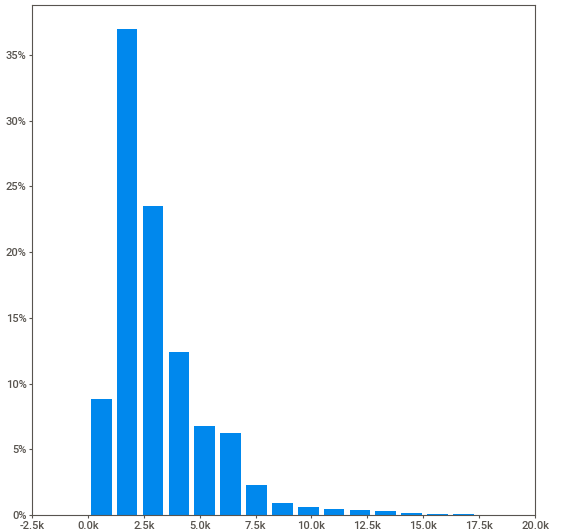
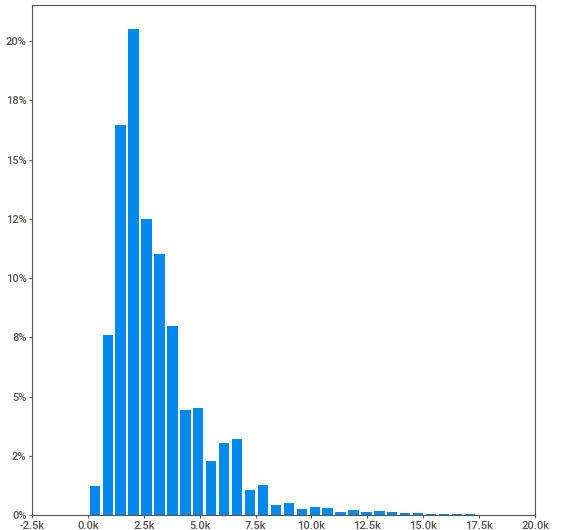
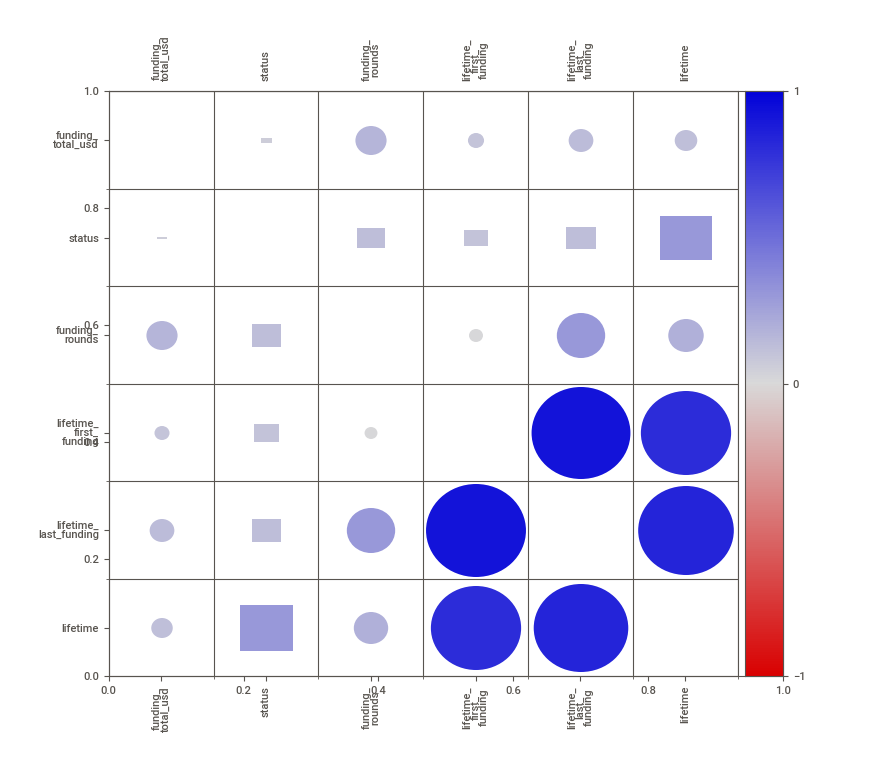
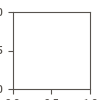

In [116]:
report = sv.analyze([train, "EDA Startups"])


report.show_notebook(scale=0.95)

* Общая структура данных в обучающей выборке:
    - Данные представлены в виде таблицы с 13 столбцами и 52 516 строками.
    - В таблице содержатся как числовые, так и категориальные признаки.
* Общая структура данных тестовой выборки:
    - Размер данных: Тестовая выборка содержит 13 125 записей (строк) и 11 столбцов.
    - Данные включают как числовые, так и категориальные признаки.
Выводы:
- Данные содержат значительное количество пропусков, особенно в столбцах closed_at, funding_total_usd и географических данных.
- Распределение funding_total_usd имеет большой разброс (от 1 USD до 30 млрд USD), что указывает на наличие выбросов.
- Большинство стартапов провели 1-2 раунда финансирования (медиана и 75-й перцентиль для funding_rounds).
- Целевой признак status имеет два уникальных значения, что указывает на бинарную классификацию.
- Целевой признак status не содержит пропусков
- Тестовая выборка содержит меньше пропусков по сравнению с обучающей выборкой.
- Признак lifetime (время существования стартапа) присутствует в тестовой выборке, но отсутствует в обучающей. Это может быть полезным признаком для модели.
- Распределение funding_total_usd имеет большой разброс (от 1 USD до 4.7 млрд USD), что указывает на наличие выбросов.
- Большинство стартапов провели 1-2 раунда финансирования (медиана и 75-й перцентиль для funding_rounds).

Дальнейшие шаги:
- Обработать пропуски:
    - Для числовых признаков (funding_total_usd) используйте медиану или среднее значение.
    - Для категориальных признаков (category_list, country_code, state_code, region, city) удалить значения или создать отдельную категорию для пропусков.
- Преобразовать временные признаки (first_funding_at, last_funding_at) в формат даты и извлеките полезные признаки (например, продолжительность между раундами финансирования)

- Использовать признак lifetime в обучающей выборке:
    - Временные признаки (founded_at, first_funding_at, last_funding_at, closed_at) нужно преобразовать в формат даты и преобразовать в новые признаки характеризующие продолжительность жизни стартапа.
    - Нужно обработать выбросы в funding_total_usd или применить логарифмическое преобразование.
    - Нужно проверить баланс классов в целевом признаке status и при необходимости примените методы борьбы с дисбалансом (например, oversampling или undersampling).

Для числового признака (funding_total_usd) заполним пропуски медианным значением

In [118]:

def fill_missing_with_median(df, column):
    median_value = df[column].median()  
    df[column] = df[column].fillna(median_value)  
    return df


train = fill_missing_with_median(train, 'funding_total_usd')


test = fill_missing_with_median(test, 'funding_total_usd')


print("Пропуски в обучающей выборке после заполнения:")
print(train['funding_total_usd'].isnull().sum())

print("\nПропуски в тестовой выборке после заполнения:")
print(test['funding_total_usd'].isnull().sum())

Пропуски в обучающей выборке после заполнения:
0

Пропуски в тестовой выборке после заполнения:
0


Для категориальных признаков (category_list, country_code, state_code, region, city) создать отдельную категорию для пропусков unknown. Для category_list - unknown_category, для country_code - unknown_country_code, для state_code - unknown_state_code, для region - unknown_region,  для rcity - unknown_city.

In [119]:

def fill_missing_categorical(df):

    df['category_list'] = df['category_list'].fillna('unknown_category')
    df['country_code'] = df['country_code'].fillna('unknown_country_code')
    df['state_code'] = df['state_code'].fillna('unknown_state_code')
    df['region'] = df['region'].fillna('unknown_region')
    df['city'] = df['city'].fillna('unknown_city')
    return df


train = fill_missing_categorical(train)

test = fill_missing_categorical(test)


print("Пропуски в обучающей выборке после заполнения:")
print(train[['category_list', 'country_code', 'state_code', 'region', 'city']].isnull().sum())

print("\nПропуски в тестовой выборке после заполнения:")
print(test[['category_list', 'country_code', 'state_code', 'region', 'city']].isnull().sum())

Пропуски в обучающей выборке после заполнения:
category_list    0
country_code     0
state_code       0
region           0
city             0
dtype: int64

Пропуски в тестовой выборке после заполнения:
category_list    0
country_code     0
state_code       0
region           0
city             0
dtype: int64


Преобразуем временные признаки (first_funding_at, last_funding_at) в формат даты и создадим новые признаки продолжительность - дней с момента основания до first_funding - lifetime_first_funding и дней с момента основания до last_funding - lifetime_last_funding.

In [120]:

for df in [train, test]:
    df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d', errors='coerce')
    df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d', errors='coerce')


if 'founded_at' in train.columns:
    train['founded_at'] = pd.to_datetime(train['founded_at'], format='%Y-%m-%d', errors='coerce')
    
   
    train['lifetime_first_funding'] = (train['first_funding_at'] - train['founded_at']).dt.days
    
   
    train['lifetime_last_funding'] = (train['last_funding_at'] - train['founded_at']).dt.days


if 'founded_at' not in test.columns:
    
    test['lifetime_first_funding'] = 0  
    test['lifetime_last_funding'] = (test['last_funding_at'] - test['first_funding_at']).dt.days


print("Обучающая выборка после преобразований:")
print(train[['founded_at', 'first_funding_at', 'last_funding_at', 'lifetime_first_funding', 'lifetime_last_funding']].head())

print("\nТестовая выборка после преобразований:")
print(test[['first_funding_at', 'last_funding_at', 'lifetime_first_funding', 'lifetime_last_funding']].head())

Обучающая выборка после преобразований:
  founded_at first_funding_at last_funding_at  lifetime_first_funding  \
0 2009-10-17       2011-05-01      2014-12-01                     561   
1 2005-01-01       2010-05-04      2014-02-25                    1949   
2 2006-01-01       2012-08-20      2014-07-02                    2423   
3 2004-01-01       2011-09-01      2014-07-18                    2800   
4 2010-05-12       2012-02-01      2012-02-01                     630   

   lifetime_last_funding  
0                   1871  
1                   3342  
2                   3104  
3                   3851  
4                    630  

Тестовая выборка после преобразований:
  first_funding_at last_funding_at  lifetime_first_funding  \
0       2009-07-01      2009-07-01                       0   
1       2010-07-28      2010-07-28                       0   
2       2014-05-15      2014-09-18                       0   
3       2005-01-01      2010-04-20                       0   
4       2

Преобразуем обучающей выборке founded_at в lifetime, для этого для стартапов со статусом closed значение lifetime рассчитаю как разницу между closed_at и founded_at, а для остальных стартапов это будет разница между report_date и founded_at

In [121]:

train['founded_at'] = pd.to_datetime(train['founded_at'], format='%Y-%m-%d', errors='coerce')
train['closed_at'] = pd.to_datetime(train['closed_at'], format='%Y-%m-%d', errors='coerce')


report_date = pd.to_datetime('2018-01-01')


train['lifetime'] = train.apply(
    lambda row: (row['closed_at'] - row['founded_at']).days 
                if row['status'] == 'closed' and pd.notna(row['closed_at']) 
                else (report_date - row['founded_at']).days 
                if pd.notna(row['founded_at']) 
                else None,
    axis=1
)


print("Обучающая выборка после преобразований:")
print(train[['founded_at', 'closed_at', 'status', 'lifetime']].head())

Обучающая выборка после преобразований:
  founded_at closed_at     status  lifetime
0 2009-10-17       NaT  operating      2998
1 2005-01-01       NaT  operating      4748
2 2006-01-01       NaT  operating      4383
3 2004-01-01       NaT  operating      5114
4 2010-05-12       NaT  operating      2791


Проверим данные на неявные дубликаты

In [122]:

def check_duplicates(df, dataset_name):
   
    duplicates = df[df.duplicated()]
    
    if duplicates.empty:
        print(f"В {dataset_name} явные дубликаты отсутствуют.")
    else:
        print(f"В {dataset_name} найдены дубликаты:")
        print(duplicates)


check_duplicates(train, "обучающей выборке (train)")


check_duplicates(test, "тестовой выборке (test)")

В обучающей выборке (train) явные дубликаты отсутствуют.
В тестовой выборке (test) явные дубликаты отсутствуют.


Проверим на неявне дубликаты, те проверим наличие строк, которые содержат одинаковую информацию, но могут быть представлены в разном формате (например, разный регистр, пробелы, опечатки или разные способы записи). Чтобы проверить на неявные дубликаты, нужно нормализовать данные (например, привести к нижнему регистру, удалить пробелы, исправить опечатки) и затем проверить дубликаты.

In [123]:
def normalize_data(df):
   
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.lower().str.strip()
    return df


def check_implicit_duplicates(df, dataset_name, subset=None):

    df_normalized = normalize_data(df.copy())
    
  
    duplicates = df_normalized[df_normalized.duplicated(subset=subset, keep=False)]
    
    if duplicates.empty:
        print(f"В {dataset_name} неявные дубликаты отсутствуют.")
    else:
     
        num_duplicates = len(duplicates)
        print(f"В {dataset_name} найдены неявные дубликаты. Количество дубликатов: {num_duplicates}")
        
        
        print("Пример дубликатов:")
        print(duplicates.sort_values(by=subset if subset else df.columns.tolist()).head())  


check_implicit_duplicates(train, "обучающей выборке (train)", subset=['name'])


check_implicit_duplicates(test, "тестовой выборке (test)", subset=['name'])

В обучающей выборке (train) неявные дубликаты отсутствуют.
В тестовой выборке (test) неявные дубликаты отсутствуют.


В тестовой и обучающей выборках обнаружено 86 и 4 неявыных дубликата. Их количество не велико, удалим их.

In [124]:
def remove_implicit_duplicates(df, subset=None):
    """
    Удаляет неявные дубликаты из DataFrame.
    
    Параметры:
    - df: DataFrame, исходные данные.
    - subset: список столбцов, по которым проверяются дубликаты. Если None, проверяются все столбцы.
    
    Возвращает:
    - DataFrame без дубликатов.
    """
  
    df_normalized = normalize_data(df.copy())
    
   
    df_no_duplicates = df_normalized.drop_duplicates(subset=subset, keep='first')
    
    return df_no_duplicates


train = remove_implicit_duplicates(train, subset=['name'])


test = remove_implicit_duplicates(test, subset=['name'])

In [125]:

check_implicit_duplicates(train, "обучающей выборке (train)", subset=['name'])


check_implicit_duplicates(test, "тестовой выборке (test)", subset=['name'])

В обучающей выборке (train) неявные дубликаты отсутствуют.
В тестовой выборке (test) неявные дубликаты отсутствуют.


Выводы по предобработке:
- Обработаны пропуски:
    - Для числового признака (funding_total_usd) использована медиана
    - Для категориальных признаков (category_list, country_code, state_code, region, city) созданы отдельные категории для пропусков unknown. Для category_list - unknown_category, для country_code - unknown_country_code, для state_code - unknown_state_code, для region - unknown_region,  для rcity - unknown_city.
- Преобраз врованы временные признаки (first_funding_at, last_funding_at) в формат даты
- Созданы новые признаки продолжительность - дней с момента основания до first_funding - lifetime_first_funding и дней с момента основания до last_funding - lifetime_last_funding.
- В обучающей выборке на основе признака founded_at сделан новый - lifetime, для этого из даты формирования выгрузки (- 2018-01-01) отнял - дату основания стартапа founded_at, либо дату закрытия для закрытых стартапов.
Возможно будет полезно укрупнить категориальные признаки, но пока не очевидно, что это потребуется, возможно удастья достичь хорошего значения метрики F1 и без этого использовав catboost.

Далее обработаем выбросы.

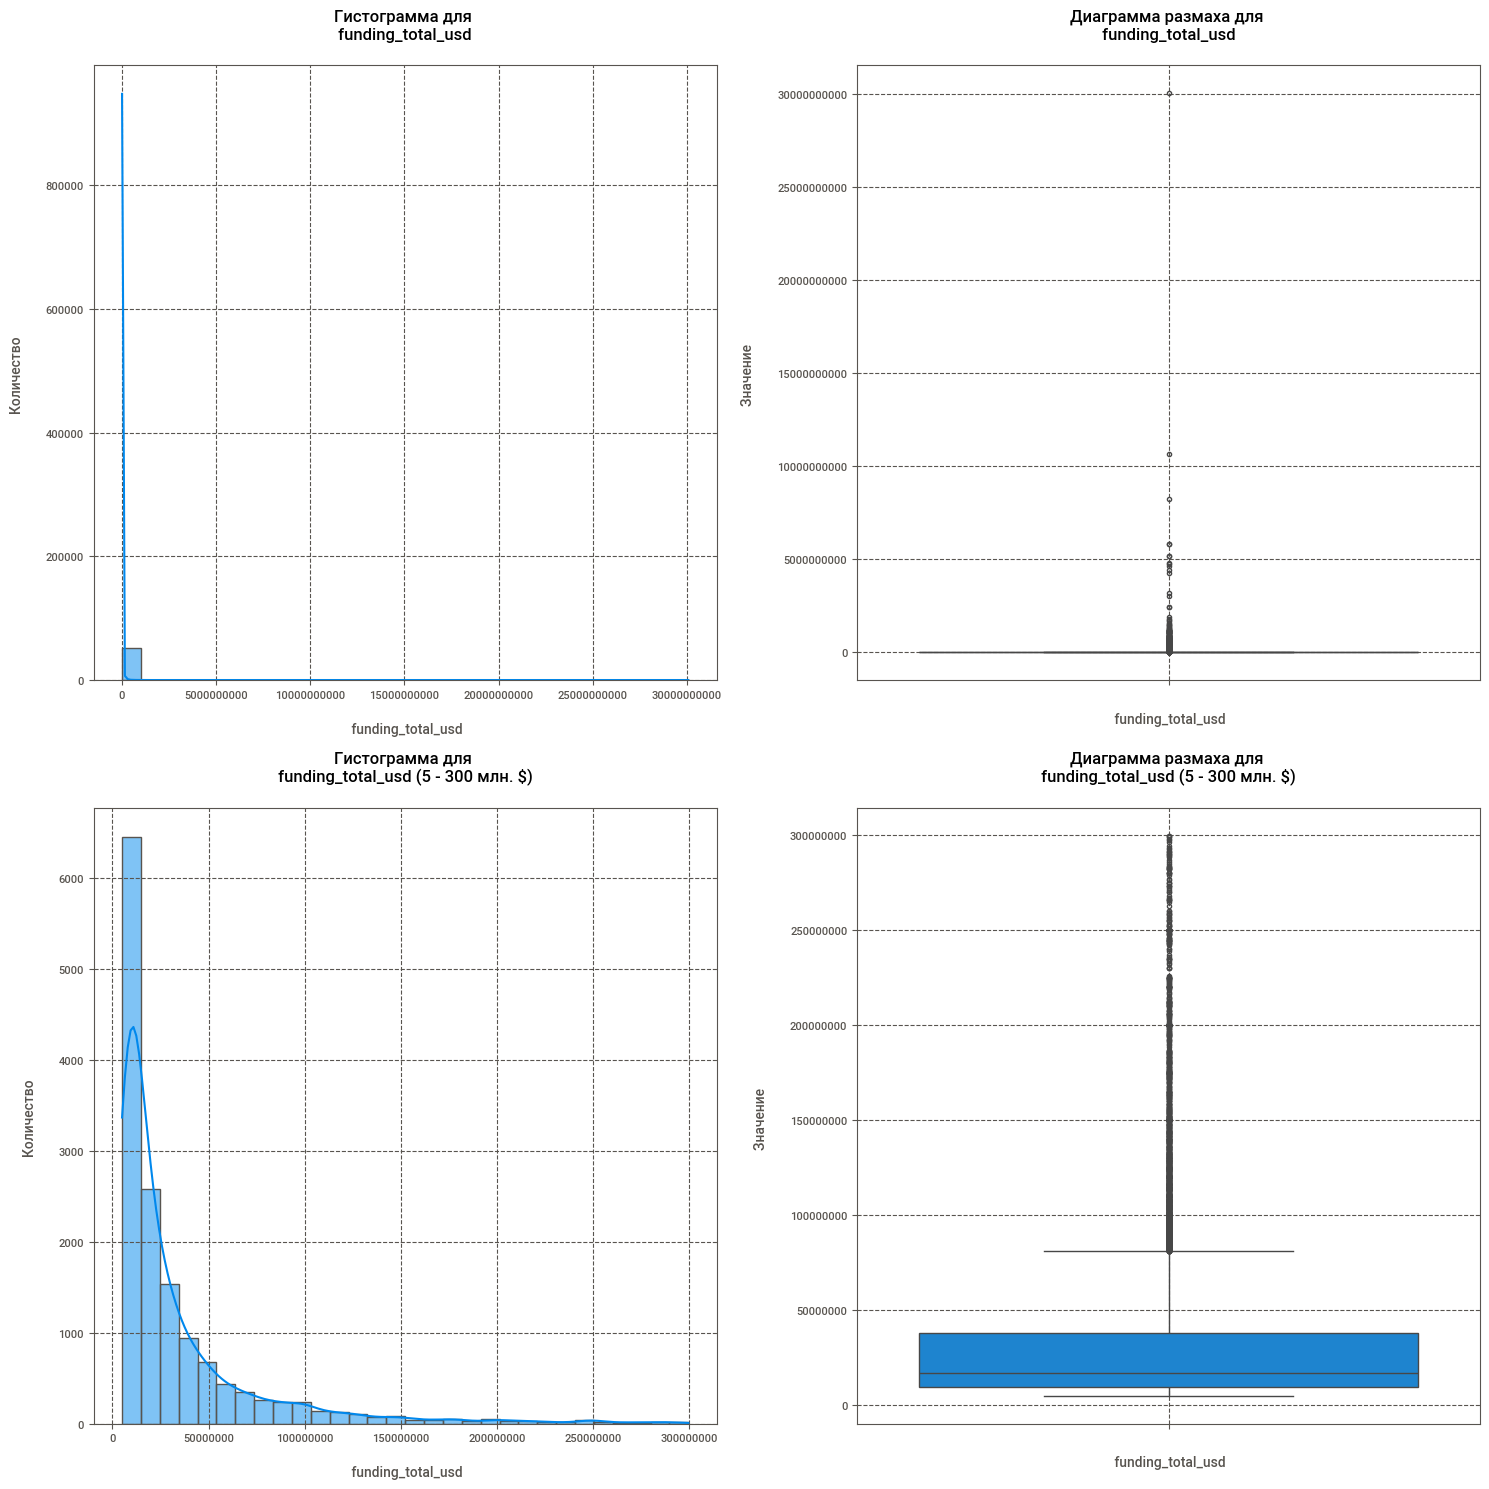

In [126]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))


def plot_graph(ax, data, column, title, xlabel, ylabel, plot_type='hist', query=None):
    if query:
        data = data.query(query)
    
    if plot_type == 'hist':
        sns.histplot(data[column], bins=30, kde=True, ax=ax)
    elif plot_type == 'box':
        sns.boxplot(y=data[column], ax=ax)
    
    ax.ticklabel_format(axis='x' if plot_type == 'hist' else 'y', style='plain')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, color='black', fontweight='bold')
    ax.grid(linestyle='--')


plot_graph(axs[0, 0], train, 'funding_total_usd', 
           'Гистограмма для \n funding_total_usd \n', 
           '\n funding_total_usd', 'Количество \n', 'hist')


plot_graph(axs[0, 1], train, 'funding_total_usd', 
           'Диаграмма размаха для \n funding_total_usd \n', 
           '\n funding_total_usd', 'Значение \n', 'box')


plot_graph(axs[1, 0], train, 'funding_total_usd', 
           'Гистограмма для \n funding_total_usd (5 - 300 млн. $) \n', 
           '\n funding_total_usd', 'Количество \n', 'hist', 
           '5000000 < funding_total_usd < 300000000')


plot_graph(axs[1, 1], train, 'funding_total_usd', 
           'Диаграмма размаха для \n funding_total_usd (5 - 300 млн. $) \n', 
           '\n funding_total_usd', 'Значение \n', 'box', 
           '5000000 < funding_total_usd < 300000000')


plt.tight_layout()
plt.show()

Из графиков можно определить границу в 90 млн. долларов как границу начала выбросов. Исключим объекты с объёмом инвестиций более 90 млн. долларов.

In [127]:
df_train = train.query('funding_total_usd < 90000000')

Выведем какой процент данных остался после подготовки данных

In [131]:
# вывожу остаток данных после EDA
print(
    f'{round(train.shape[0] / train_shape[0] * 100, 2)}%'
    f' - доля данных после подготовки данных в тренировочной выборке')

99.92% - доля данных после подготовки данных в тренировочной выборке


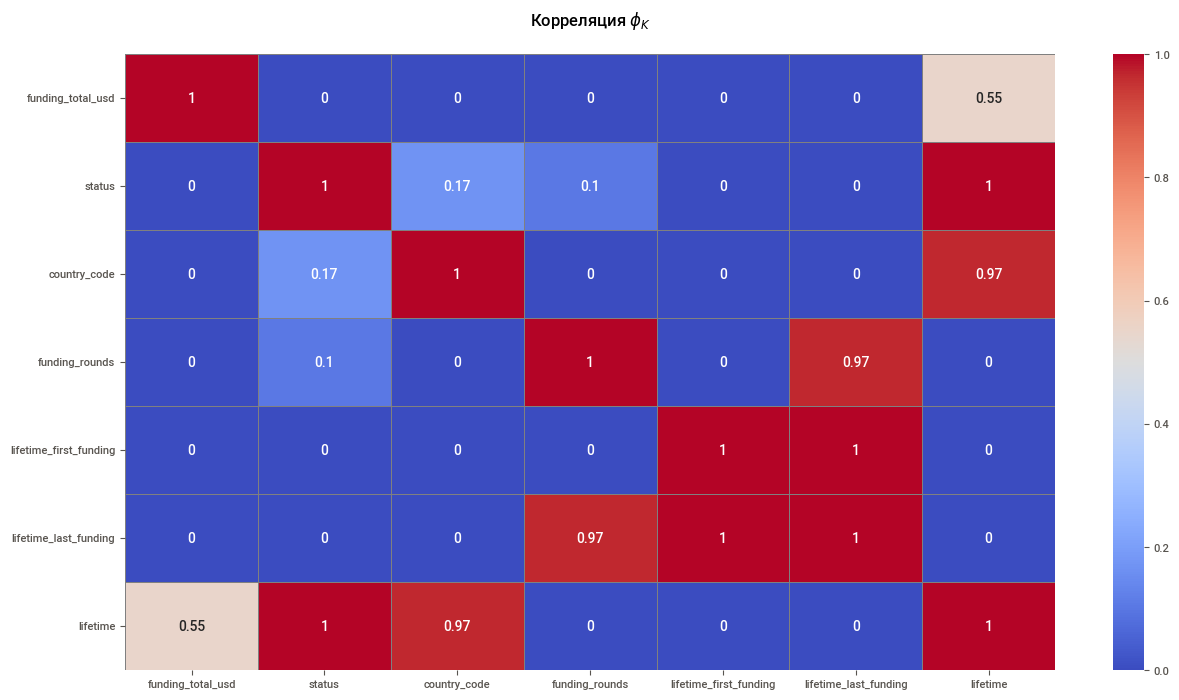

In [129]:
cols_to_drop = [
    'name', 'category_list', 'state_code', 'region', 'city', 
    'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'
]


check_corr = train.drop(cols_to_drop, axis=1).sample(1000).phik_matrix(interval_cols=['funding_total_usd'])


plt.figure(figsize=(15, 8))
sns.heatmap(
    check_corr,
    annot=True,
    fmt='.2g',
    vmin=0,
    vmax=1,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='grey',
    square=False  
)
plt.title('Корреляция $\phi_K$ \n')
plt.show()

`funding_total_usd`:
     - Имеет высокую корреляцию (0.79) с `lifetime_first_funding`.
     - Имеет полную корреляцию (1.0) с `lifetime_last_funding`.
     - Имеет умеренную корреляцию (0.5) с `country_code`.
     - Имеет слабую корреляцию (0.46) с `funding_rounds`.


`status`:
     - Имеет очень высокую корреляцию (0.99) с `lifetime`.
     - Имеет умеренную корреляцию (0.27) с `country_code`.
     - Имеет слабую корреляцию (0.072) с `funding_rounds`.

`country_code`:
     - Имеет умеренную корреляцию (0.5) с `funding_total_usd`.
     - Имеет умеренную корреляцию (0.27) с `status`.
     - Имеет высокую корреляцию (0.89) с `lifetime`.


`funding_rounds`:
     - Имеет слабую корреляцию (0.46) с `funding_total_usd`.
     - Имеет очень высокую корреляцию (0.88) с `lifetime_first_funding`.
     - Имеет очень высокую корреляцию (0.99) с `lifetime_last_funding`.


`lifetime_first_funding`:
     - Имеет высокую корреляцию (0.79) с `funding_total_usd`.
     - Имеет очень высокую корреляцию (0.88) с `funding_rounds`.
     - Имеет полную корреляцию (1.0) с `lifetime_last_funding`.

`lifetime_last_funding`:
     - Имеет полную корреляцию (1.0) с `funding_total_usd` и `lifetime_first_funding`.
     - Имеет очень высокую корреляцию (0.99) с `funding_rounds`.


`lifetime`:
     - Имеет очень высокую корреляцию (0.99) с status.
     - Имеет высокую корреляцию (0.89) с country_code.



Выводы:
   - Высокая корреляция между `funding_total_usd` и `lifetime_first_funding` (0.79) указывает на то, что стартапы, которые быстрее привлекают финансирование, имеют больше шансов на успех получения инвестиций.
   - Высокая корреляция между `lifetime` и `country_code` (0.89) может указывать на то, что продолжительность жизни стартапа тесно связана с его местоположением.
   - Очень высокая корреляция между `status` и `lifetime` (0.99) может указывать на то, что на статус стартапа ("закрыт" или "действующий") сильно влияет его продолжительность жизни.

In [134]:
train.to_csv('train_data.csv', index=False)

1. Убрать все библиотеки кроме первой+
2. Исправить расчет lifetime для закрытых+
3. Убрать везде комментарии+
4. Поправить, что говорил Иван +
5. Новый ноутбук (оформить EDA)+
6. Подготовить выборку ()+
7. В следующий раз обучение

In [130]:
import pandas as pd

train_labels = df['status']

def replace_values(x):
    if x == 'operating':
        return 0
    elif x == 'closed':
        return 1

train_labels = train_labels.apply(replace_values)
train_labels


KeyError: 'status'

In [ ]:
train_data = df.drop("status", axis=1)

In [ ]:
cat_features = list(train_data.select_dtypes(include = 'object').columns)

In [ ]:
from catboost import CatBoostClassifier, Pool


# РАЗОБРАТЬСЯ КАК ВОТ ЗДЕСЬ ПОДАВАТЬ СПИСОК КАТЕГОРИАЛЬНЫХ ЗНАЧЕНИЙ
test_data = catboost_pool = Pool(train_data,
                                 train_labels,
                                 cat_features=cat_features)

model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
model.fit(train_data, train_labels)
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)

С категориями для отраслей нужно что-то делать. Проредить и укрупнить.

фик корреляция не будет отрабатывать, если ничего не сделать с признаками

Свой энкодер который присваивает единички в нужных местах

Пайплайны
- Через них удобнее

Что делать когда много 
Забить и посмотреть что получится
- Лог регрессия и дерево не будут работать
Второй вариант укрупнять категории. Кто-то озаботился словариком - это круто. 
Если много улететь в категорию прочие, что это неправильно. 

Третий вариант: можно пробовать NLP - представить строку в виде вектора, чтобы близкие буквы давали близкие сегменты, а разные буквы - далекие.
ТF DF кодирование по встречаемости символов - плохо работает
Представить в виде векторов. Ворд то век. Рядом будут близкие понятия.
Брать Берт или аналоги и смотреть что получится. Чтобы она выдавала эмбендинги.
Один столбец с текстом превращаем в значения векторов и подаем это в модель типа бустинга
